# Chap 18 - Ex1: Apply ARIMA for candy_production.csv data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [2]:
candy_production = pd.read_csv('data/candy_production.csv', index_col = 0)

candy_production.index = pd.to_datetime(candy_production.index, dayfirst=False, yearfirst=True)

candy_production

IPG3113N
observation_date          
1972-01-01         85.6945
1972-02-01         71.8200
1972-03-01         66.0229
1972-04-01         64.5645
1972-05-01         65.0100
...                    ...
2017-04-01        107.4288
2017-05-01        101.9209
2017-06-01        104.2022
2017-07-01        102.5861
2017-08-01        114.0613

[548 rows x 1 columns]

In [3]:
candy_production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 1972-01-01 to 2017-08-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPG3113N  548 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


## <span style  = 'color:yellow'> Check the seasonal feature of the time series data

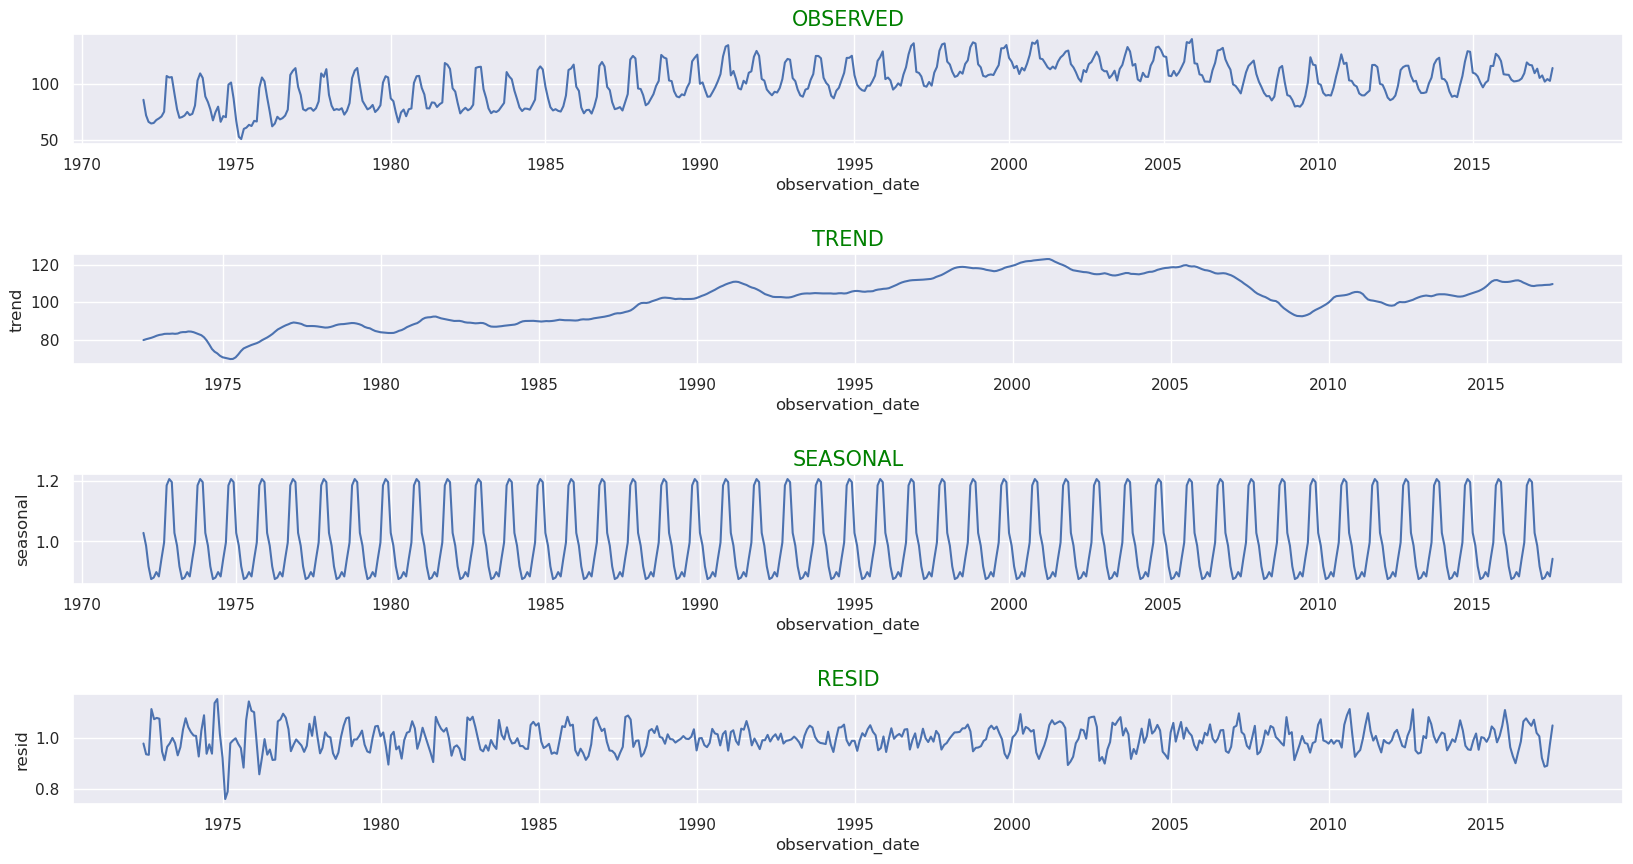

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_check = seasonal_decompose(candy_production, model='multiplicative')

attr = ['observed', 'trend', 'seasonal', 'resid']

sbn.set_theme(style='darkgrid')
plt.figure(figsize = (20,10))
plt.subplots_adjust(hspace=1)
for i in range(len(attr)):
    plt.subplot(4,1,i+1)
    sbn.lineplot(data=getattr(seasonal_check, attr[i]))
    plt.title(attr[i].upper(), size = 15, color = 'green')
plt.show()

## <span style  = 'color:yellow'> Build SARIMA model (because the data has seasonality)

In [5]:
import pmdarima as pm

train_set, test_set = pm.model_selection.train_test_split(candy_production, train_size=int(0.8*candy_production.shape[0]))

arima_model = pm.auto_arima(train_set,                 
                start_p = 2, max_p = 5,
                start_q = 2, max_q = 5,
                m=7, seasonal = True,
                suppress_warnings=True, 
                stepwise=True, trace = True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3198.147, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3134.310, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3141.488, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3196.147, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3170.778, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=3129.279, Time=0.25 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=3125.622, Time=0.35 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=3125.059, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=3139.735, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=3120.483, Time=0.34 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=3141.508, Time=0.19 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=3144.039, Time=0.27 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=3

## <span style  = 'color:yellow'> Forecast

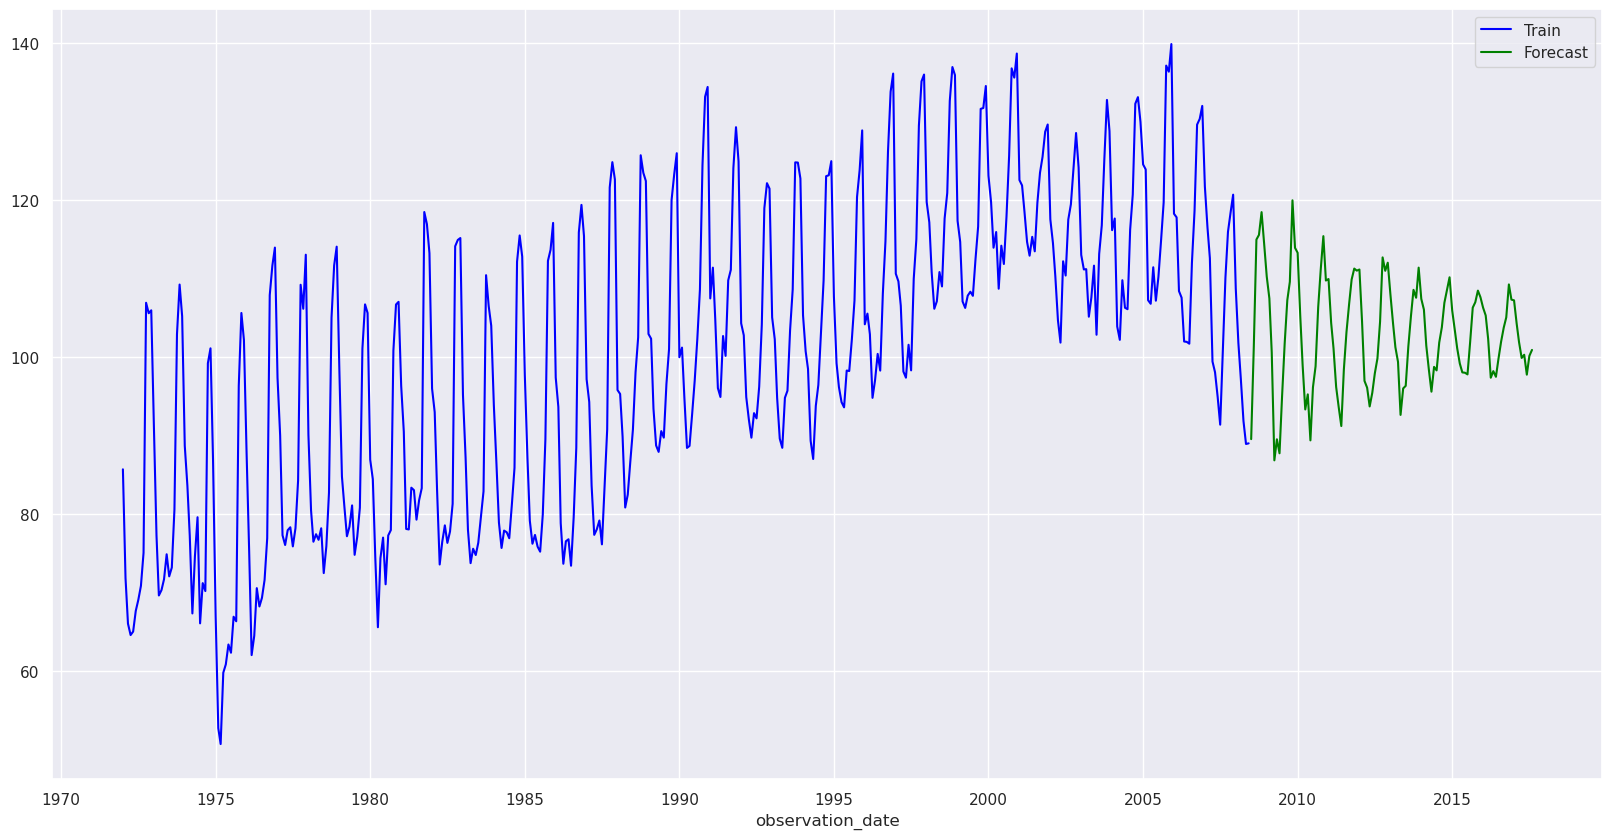

In [40]:
forecasts_test = arima_model.predict(test_set.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(20, 10))
sbn.lineplot(x=train_set.index, y=train_set.values.ravel(), color='blue', label='Train')
sbn.lineplot(x=forecasts_test.index, y=forecasts_test.values.ravel(), color='green', label='Forecast')
plt.legend()
plt.show()

## <span style  = 'color:yellow'> Evaluation

Accuracy on train  set: -0.20658434305395468
Accuracy on test  set: 0.5068761609812698

Mean squared error test set: 71.85310597055755
Mean absolute error test set: 6.867042401571668



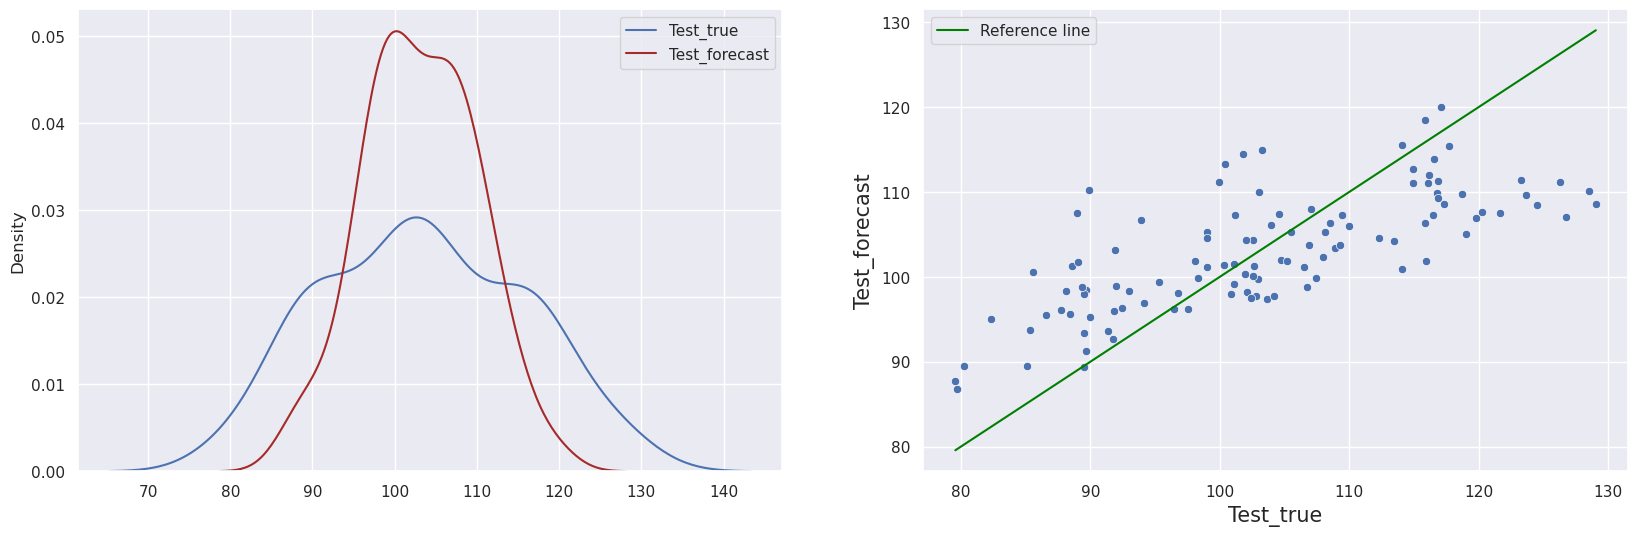

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecasts_train = arima_model.predict(train_set.shape[0])

print(f'Accuracy on train set: {r2_score(train_set.values, forecasts_train.values)}')
print(f'Accuracy on test set: {r2_score(test_set.values, forecasts_test.values)}')
print()

print(f'Mean squared error test set: {mean_squared_error(test_set.values, forecasts_test.values)}')
print(f'Mean absolute error test set: {mean_absolute_error(test_set.values, forecasts_test.values)}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sbn.kdeplot(test_set.values,  label = "Test_true", color = 'green')
sbn.kdeplot(forecasts_test.values, label = "Test_forecast", color = 'brown')
plt.legend()

plt.subplot(1,2,2)
sbn.lineplot(x = [test_set.values.min(), test_set.values.max()], 
             y = [test_set.values.min(), test_set.values.max()], 
             label = 'Reference line', color = 'green')
sbn.scatterplot(x = test_set.values.ravel(), y = forecasts_test.values.ravel())
plt.xlabel("Test_true", size=15)
plt.ylabel("Test_forecast", size=15)
plt.show()